In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Importing Required Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
import re
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
cd /content/drive/MyDrive/NLP/data

/content/drive/.shortcut-targets-by-id/1Xs42ejjNPdRpEPK-IPgs-Q0FzX-gaUh5/NLP/data


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

Creating Data Frame

In [ ]:
FakeDf = pd.read_csv("Fake.csv")

In [ ]:
fake = FakeDf
FakeDf.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
TrueDf = pd.read_csv("True.csv")
real = TrueDf
TrueDf.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Visualizations

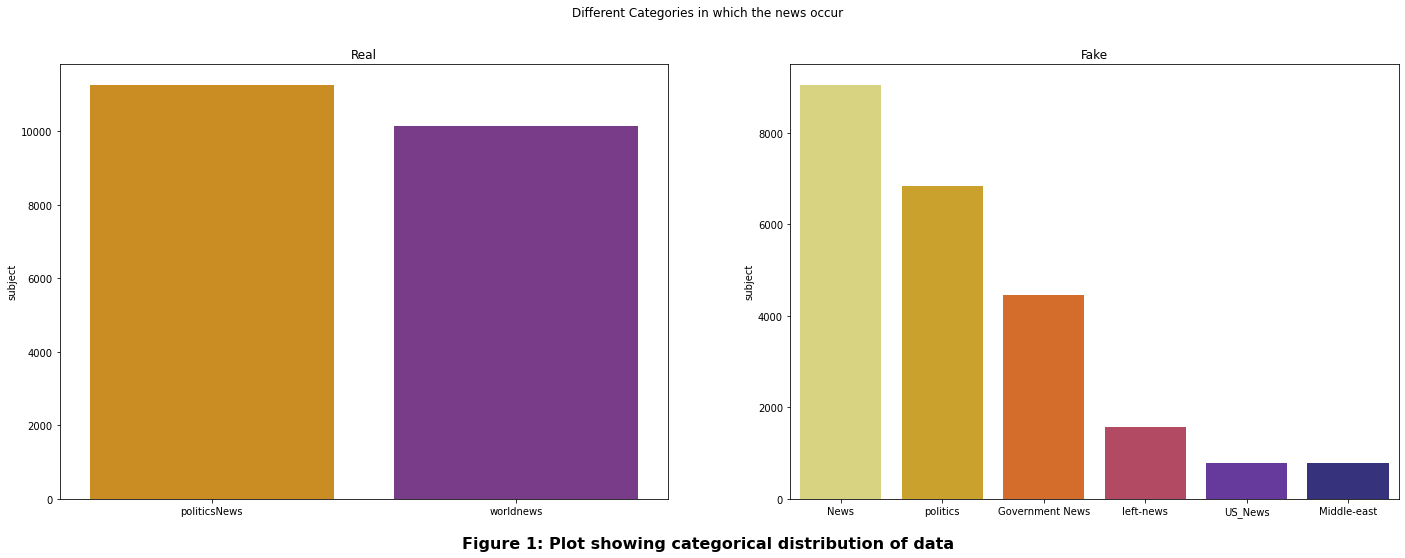

In [ ]:
def CategoriesPlot():
  f, axes = plt.subplots(1,2, figsize=(24,8))
  # sns.set(rc={'figure.figsize':(25,8)})
  f.text(0.5, 0.04, 'Figure 1: Plot showing categorical distribution of data', ha='center', size=16, fontweight="bold")
  sns.barplot(list(real.subject.unique()),real.subject.value_counts(), palette='CMRmap_r', ax=axes[0])
  sns.barplot(list(fake.subject.unique()),fake.subject.value_counts(), palette='CMRmap_r', ax=axes[1])
  axes[0].set_title("Real")
  axes[1].set_title("Fake")
  f.suptitle("Different Categories in which the news occur");

CategoriesPlot()

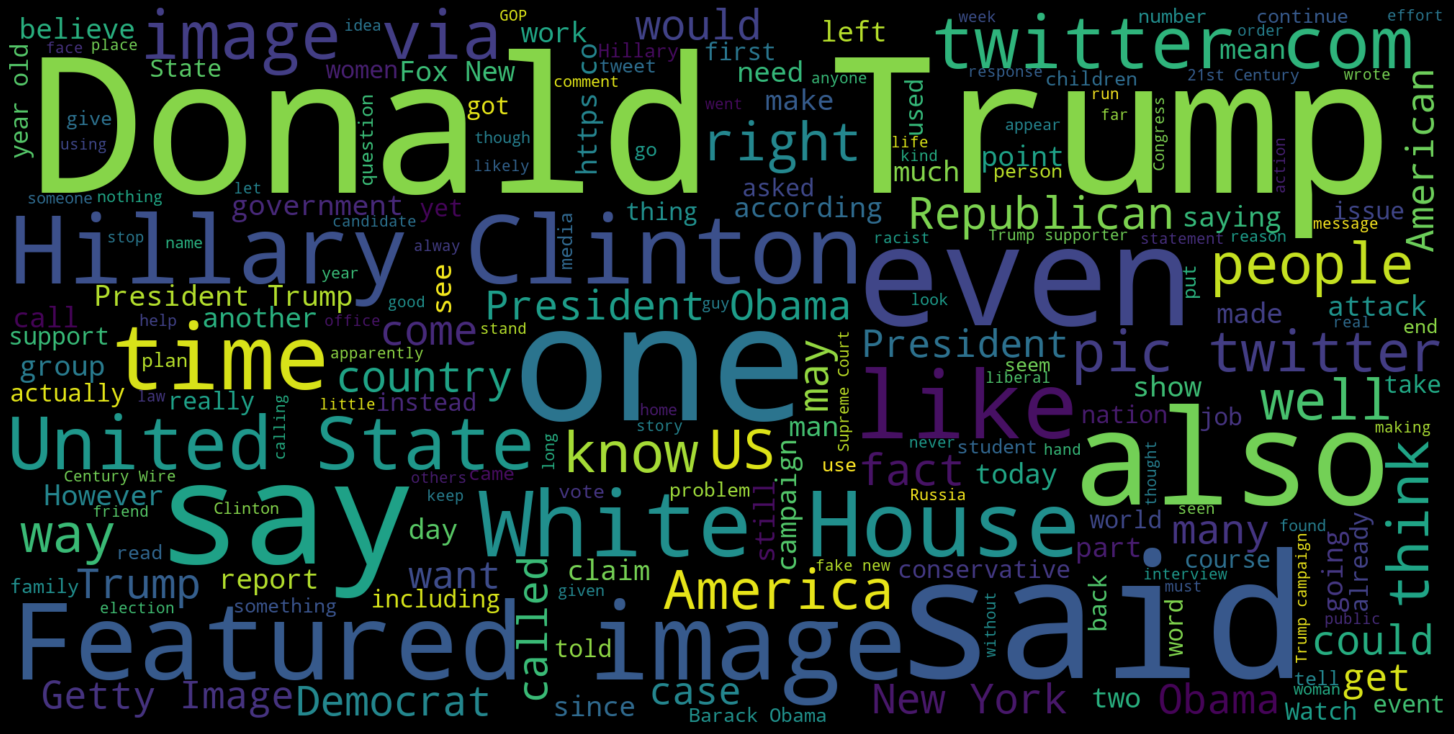

In [ ]:
#Word Cloud
def createWordcloud(df):
  text = ''
  for news in df.text.values:
      text += f" {news}"
  wordcloud = WordCloud(
      width = 2000,
      height = 1000,
      background_color = 'black',
      stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
  fig = plt.figure(
      figsize = (20, 10),
      facecolor = 'k',
      edgecolor = 'k')
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()
  del text
createWordcloud(fake)

# Cleaning The Data

In [ ]:
unknown_publishers = []
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [ ]:
real.iloc[unknown_publishers].text

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [ ]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)

        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [ ]:
#Replace existing text column with new text
#add seperate column for publication info
real["publisher"] = publisher
real["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [ ]:
real = real.drop([index for index,text in enumerate(real.text.values) if str(text).strip() == ''])

In [ ]:
fake = fake.drop([index for index,text in enumerate(fake.text.values) if str(text).strip() == ''])

In [ ]:
len([index for index,text in enumerate(fake.text.values) if str(text).strip() == ''])

0

## Text Preprocessing

In [ ]:
real['class'] = 1
fake['class'] = 0

In [ ]:
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [ ]:
real.head()

,title,text,subject,date,publisher,class
0,"As U.S. budget fight looms, Republicans flip t...","As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
1,U.S. military to accept transgender recruits o...,U.S. military to accept transgender recruits o...,politicsNews,"December 29, 2017",WASHINGTON (Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
3,FBI Russia probe helped by Australian diplomat...,FBI Russia probe helped by Australian diplomat...,politicsNews,"December 30, 2017",WASHINGTON (Reuters),1
4,Trump wants Postal Service to charge 'much mor...,Trump wants Postal Service to charge 'much mor...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters),1


In [ ]:
real = real.drop(["subject", "date","title",  "publisher"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

In [ ]:
data = real.append(fake, ignore_index=True)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Removing StopWords, Punctuations and single-character words

In [ ]:
y=data["class"].values
def preprocess(data):
  X = []
  stop_words = set(nltk.corpus.stopwords.words("english"))
  tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
  for s in data['text'].values:
    tmp=[]
    sentences = nltk.sent_tokenize(s)
    for sent in sentences:
      sent = sent.lower()
      tokens = tokenizer.tokenize(sent)
      filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w)>1]
      tmp.extend(filtered_words)
    X.append(tmp)
  return X
X=preprocess(data)


###Word2Vec

In [ ]:
import gensim
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
len(w2v_model.wv.vocab) #This gives us the vocabulary size

122238

In [ ]:
w2v_model['trump']

array([-0.26639247,  1.7989618 ,  0.8440695 ,  0.41482848, -0.29916894,
       -2.4233322 , -0.00926031, -1.7469157 , -0.10462254, -0.18524218,
       -0.06323316,  1.2509769 ,  0.43483797, -0.29424798,  2.1189432 ,
       -1.9877452 ,  2.626864  ,  0.41088638,  1.9436533 ,  1.3389423 ,
       -1.398555  , -0.01420543,  2.8251925 ,  2.4321752 ,  1.2696112 ,
        0.9221397 ,  0.4718038 ,  1.1711892 , -1.21816   , -0.10488335,
       -0.30895686, -2.189914  ,  1.5342269 ,  1.8213979 ,  1.3734678 ,
        1.9196469 ,  1.3180053 , -1.7079496 ,  2.8866017 ,  3.7495582 ,
        1.3824165 , -1.8770137 ,  0.8846026 ,  0.24524048, -0.32048196,
        0.23326038,  1.4453139 ,  0.1778744 , -1.9708291 ,  0.48516497,
       -0.2246381 ,  0.2456553 ,  3.7451453 , -0.5623548 ,  3.1911182 ,
        0.11447871,  0.2209589 ,  0.50371015,  1.1484406 , -2.089248  ,
        3.9750338 , -0.12871823, -1.1296909 ,  0.9793876 ,  2.733193  ,
        1.2037485 ,  0.3188253 , -2.3633742 ,  1.8309968 ,  0.99

In [ ]:
w2v_model.wv.most_similar("trump")

[('elect', 0.6358063817024231),
 ('cruz', 0.5317858457565308),
 ('conway', 0.48725438117980957),
 ('sidetracks', 0.485109806060791),
 ('course', 0.48162534832954407),
 ('outright', 0.48134684562683105),
 ('hillary', 0.4738113284111023),
 ('gxfmzx6zbl', 0.4720943868160248),
 ('actually', 0.4707253575325012),
 ('obama', 0.4690968692302704)]

In [ ]:
w2v_model.wv.most_similar(positive=["obama", "clinton"])

[('trump', 0.5622049570083618),
 ('bush', 0.5304808616638184),
 ('incoming', 0.5006852149963379),
 ('obamahe', 0.4969653785228729),
 ('crooked', 0.47729426622390747),
 ('clintons', 0.47375741600990295),
 ('bartlet', 0.47260990738868713),
 ('lacklustre', 0.45917120575904846),
 ('nmlwydsepo', 0.4570731520652771),
 ('americas_dad', 0.44278648495674133)]

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [ ]:
X[0][:10]

[389, 395, 10493, 54, 5505, 1285, 4840, 315, 205, 16]

In [ ]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
also -> 9
obama -> 10


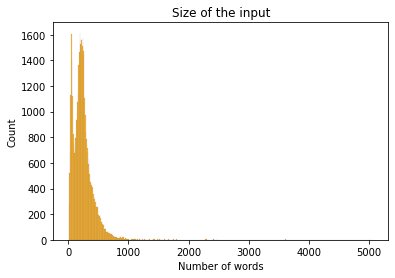

In [ ]:
sns.histplot([len(x) for x in X], bins=500, color='Orange')
plt.title("Size of the input")
plt.xlabel('Number of words')
plt.show()

# we can see that the data is skewed to the left and some outlietrs are there with words greater than 3.5k
#so lets truncate the sentences to 700 to handle these outliers

In [ ]:

nos = np.array([len(x) for x in X])
len(nos[nos  < 700])

43352

In [ ]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
len(X[1])

700

In [ ]:
vocab_size = len(tokenizer.word_index) + 1 #To compensate for the indxing from 0 of Embedding

In [ ]:
vocab_size
file = open('vocsize.txt', 'w')
file.write(str(vocab_size))
file.close()

In [ ]:
# A funcrtion to craete a weight matrix

def get_weight_matrix(model, vocab):
  vocab_size = len(vocab) + 1
  weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
  for word, i in vocab.items():
    weight_matrix[i] = model[word]
  return weight_matrix

embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [ ]:
np.savetxt('embed.txt', embedding_vectors)

In [ ]:
import keras
import tensorflow as tf
from keras.utils.vis_utils import plot_model

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/assets


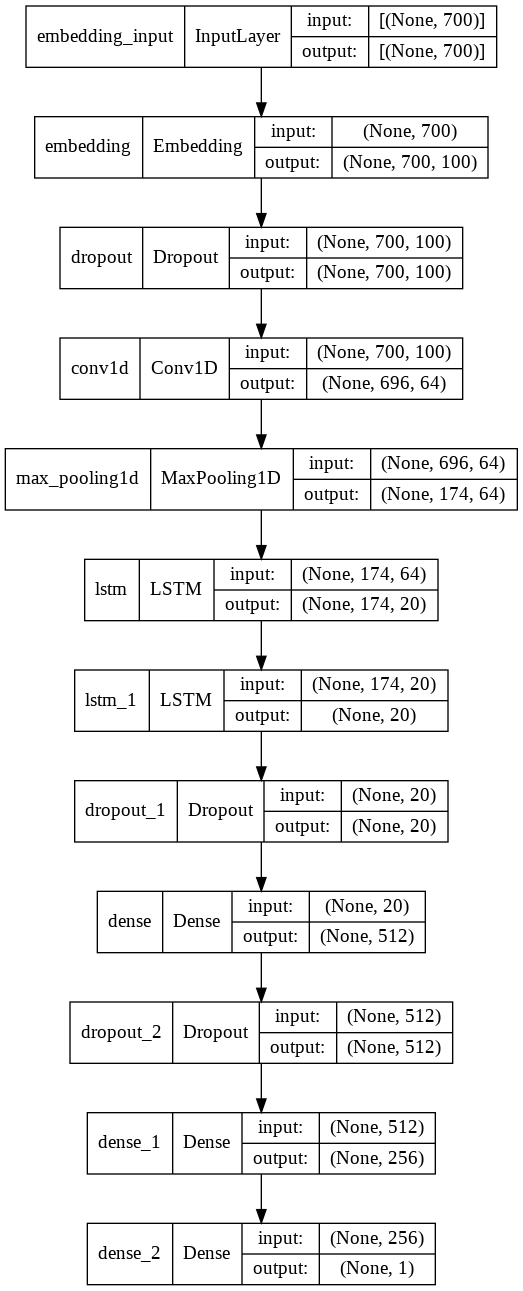

In [ ]:
#Defining Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.save('/content/drive/MyDrive/NLP')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, )

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          12223900  
                                                                 
 dropout (Dropout)           (None, 700, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 696, 64)           32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 174, 64)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 174, 20)           6800      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                        

In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
727/727 [==============================] - 74s 83ms/step - loss: 0.1527 - accuracy: 0.9409 - val_loss: 0.0641 - val_accuracy: 0.9760
Epoch 2/6
727/727 [==============================] - 60s 82ms/step - loss: 0.0554 - accuracy: 0.9820 - val_loss: 0.0527 - val_accuracy: 0.9823
Epoch 3/6
727/727 [==============================] - 60s 82ms/step - loss: 0.0419 - accuracy: 0.9849 - val_loss: 0.0344 - val_accuracy: 0.9887
Epoch 4/6
727/727 [==============================] - 59s 82ms/step - loss: 0.0279 - accuracy: 0.9906 - val_loss: 0.0294 - val_accuracy: 0.9894
Epoch 5/6
727/727 [==============================] - 59s 81ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 0.0285 - val_accuracy: 0.9904
Epoch 6/6
727/727 [==============================] - 59s 81ms/step - loss: 0.0172 - accuracy: 0.9945 - val_loss: 0.0428 - val_accuracy: 0.9886


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [ ]:
accuracy_score(y_test, y_pred)

0.9915966386554622

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5713
           1       1.00      0.99      0.99      5354

    accuracy                           0.99     11067
   macro avg       0.99      0.99      0.99     11067
weighted avg       0.99      0.99      0.99     11067



WEB SCRAPING POLTIFACT

In [ ]:
from bs4 import BeautifulSoup
import urllib.request,sys,time
import requests
import pandas as pd

In [ ]:
pagesToGet= 5

upperframe=[]
for page in range(1,pagesToGet+1):
    #print('processing page :', page)
    url = 'https://www.politifact.com/factchecks/list/?page='+str(page)
    #print(url)

    #an exception might be thrown, so the code should be in a try-except block
    try:
        #use the browser to get the url. This is suspicious command that might blow up.
        page=requests.get(url)                             # this might throw an exception if something goes wrong.

    except Exception as e:                                   # this describes what to do if an exception is thrown
        error_type, error_obj, error_info = sys.exc_info()      # get the exception information
        print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
        print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
        continue                                              #ignore this page. Abandon this and go back.
    time.sleep(2)
    soup=BeautifulSoup(page.text,'html.parser')
    frame=[]
    links=soup.find_all('li',attrs={'class':'o-listicle__item'})
    #print(len(links))
    filename="NEWS.csv"
    f=open(filename,"w", encoding = 'utf-8')
    headers="Statement,Link,Date, Source, Label\n"
    f.write(headers)

    for j in links:
        Statement = j.find("div",attrs={'class':'m-statement__quote'}).text.strip()
        Link = "https://www.politifact.com"
        Link += j.find("div",attrs={'class':'m-statement__quote'}).find('a')['href'].strip()
        page1=requests.get(Link)
        soup1=BeautifulSoup(page1.text,'html.parser')
        links1=soup1.find_all('article',attrs={'class':'m-textblock'})
        Text=links1[0].find('p').text.strip()
        Date = j.find('div',attrs={'class':'m-statement__body'}).find('footer').text[-14:-1].strip()
        Source = j.find('div', attrs={'class':'m-statement__meta'}).find('a').text.strip()
        Label = j.find('div', attrs ={'class':'m-statement__content'}).find('img',attrs={'class':'c-image__original'}).get('alt').strip()
        frame.append((Statement,Source,Text,Label))
        f.write(Statement.replace(",","^")+","+Source.replace(",","^")+","+Text.replace(",","^")+","+Label.replace(",","^")+"\n")
    upperframe.extend(frame)
f.close()
data=pd.DataFrame(upperframe, columns=['Statement','Source','Text','Label'])
data.head()


,Statement,Source,Text,Label
0,Says Google Earth blocked people from seeing t...,Facebook posts,A giant container ship that found itself stuck...,false
1,“We spent billions on a border wall and quit w...,Facebook posts,A Facebook post claims that construction of a ...,barely-true
2,A Georgia law has not “criminalized giving peo...,Josh Holmes,"On ""Fox News Sunday,"" host Chris Wallace and a...",barely-true
3,"""There are 43 states that have now passed vote...",James Clyburn,One of the biggest political controversies tod...,false
4,"""Joe Biden forced the U.S. Attorney for the Ea...",Tweets,A viral tweet suggests President Joe Biden may...,barely-true


In [ ]:
data['Label'].unique()

array([0, 1, 'full-flop'], dtype=object)

In [ ]:
data=data[data['Label']!='barely-true']
data=data[data['Label']!='half-true']

In [ ]:
data['Label']=data['Label'].replace(['false','pants-fire','full-flop'],0)
data['Label']=data['Label'].replace(['true','mostly-true'],1)

In [ ]:
data.head()

,Statement,Source,Text,Label,text
0,Says Google Earth blocked people from seeing t...,Facebook posts,A giant container ship that found itself stuck...,0,Says Google Earth blocked people from seeing t...
3,"""There are 43 states that have now passed vote...",James Clyburn,One of the biggest political controversies tod...,0,"""There are 43 states that have now passed vote..."
8,"""Ted Cruz says owning a gun should be as hassl...",Facebook posts,Days after a Colorado gunman opened fire in a ...,0,"""Ted Cruz says owning a gun should be as hassl..."
9,“There’s still (only) a handful of school dist...,Tony Evers,"Wisconsin students, parents and educators shou...",1,“There’s still (only) a handful of school dist...
10,"“In a majority of states, new voters are able ...",Alex Padilla,Shortly after high-profile mass shootings in G...,1,"“In a majority of states, new voters are able ..."


In [ ]:
data['text']=data['Statement']+ " " + data['Text']

In [ ]:
X_test_1=preprocess(data)

In [ ]:
w2v_model = gensim.models.Word2Vec(sentences=X_test_1, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
X_test_1 = tokenizer.texts_to_sequences(X_test_1)

In [ ]:
X_test_1 = pad_sequences(X_test_1, maxlen=maxlen)

In [ ]:
y_pred = (model.predict(X_test_1) >= 0.5).astype("int")

In [ ]:
y_test=data['Label']

In [ ]:
accuracy_score(y_test, y_pred)

0.6666666666666666

WEBSCRAPPING TIMES OF INDIA

In [ ]:
import requests
import time
from bs4 import BeautifulSoup
def timesofindia():
    url = "https://timesofindia.indiatimes.com/home/headlines"
    page_request = requests.get(url)
    data = page_request.content
    soup = BeautifulSoup(data,"html.parser")

    counter = 0
    title=[]
    text=[]
    for divtag in soup.find_all('div', {'class': 'headlines-list'}):
        for ultag in divtag.find_all('ul', {'class': 'clearfix'}):
            if (counter <= 20):
                for litag in ultag.find_all('li'):

                    x="https://timesofindia.indiatimes.com" + litag.find('a')['href']

                    try:
                      page_r = requests.get(x)
                    except:
                      print("Connection refused by the server..")

                      time.sleep(5)

                      continue
                    #page_r=requests.get(x)
                    #print(x)
                    data_1=page_r.content
                    soup1=BeautifulSoup(data_1,"html.parser")
                    y=x.split('/')[-1].split('.')[0]
                    #print(y)
                    for dtag in soup1.find_all('div',{'class':'fewcent-'+y}):
                      text.append(dtag.text.strip())
                      if(len(dtag.text.strip())!=0):
                        title.append(litag.find('a')['title'])
                        counter = counter + 1

    return title,text

if __name__ == "__main__":
    x,y=timesofindia()

Connection refused by the server..
Connection refused by the server..
Connection refused by the server..


In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(list(zip(x, y)),
               columns =['title', 'text'])

In [ ]:
df['class']=1

In [ ]:
df.head()

,title,text,class
0,A new dawn of political bonhomie in Tamil Nadu,The chief minister MK stalin has deputed 22 mi...,1
1,90% patients who got fake Remdesivir in MP bea...,The Centre has told states that Remdesivir may...,1
2,Aus bowlers were aware of ball-tampering tacti...,"Cameron Bancroft (in picture), along with Stev...",1
3,Google leads effort to support work visas for ...,WASHINGTON: Google is leading a determined eff...,1
4,Why is Bhuvneshwar not in squad for England tour?,TAKING THE SHORTER ROUTE? Bhuvneshwar Kumar ma...,1


In [ ]:
X_test_1=preprocess(df)

In [ ]:
w2v_model = gensim.models.Word2Vec(sentences=X_test_1, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
X_test_1 = tokenizer.texts_to_sequences(X_test_1)

In [ ]:
X_test_1 = pad_sequences(X_test_1, maxlen=maxlen)

In [ ]:
y_pred = (model.predict(X_test_1) >= 0.5).astype("int")

In [ ]:
y_test=df['class']

In [ ]:
accuracy_score(y_test,y_pred)

0.75